In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from ord2011 import ORD2011

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def get_high_fitness(ga_result):
    best_individual = ga_result.generations[0][0]

    for i, gen in enumerate(ga_result.generations):
        best_in_gen = ga_result.get_high_fitness_individual(i)
        if best_in_gen.fitness > best_individual.fitness:            
            best_individual = best_in_gen

    return best_individual

In [3]:
'''
O'Hara-Rudy 2011
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
protocol = vc_protocols.hERG_CiPA()
# protocol = pickle.load(open("./trial_steps_ramps_Kernik_200_50_4_-120_60_paper/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl", 'rb'))
protocol = pickle.load(open("./trial_steps_ramps_ORD2011_288_51_4_-121_61/shortened_trial_steps_ramps_ORD2011_288_51_4_-121_61_500_artefact_False_short.pkl", 'rb'))
protocol = pickle.load(open("./trial_steps_ramps_ORD2011_256_64_4_-120_60/shortened_trial_steps_ramps_ORD2011_256_64_4_-120_60_500_artefact_False_short.pkl", 'rb'))

window=20
step_size=5
end_time = protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 10000)
print(end_time)

610.0


In [4]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-8, vhold=protocol.get_voltage_at_time(0)) # 1e-12, 1e-14 # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.0001
sim_myokit.name = "ORD2011"

In [5]:
start_time = time.time()

# sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
# y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d = sim_myokit.simulate(end_time, log_times=None, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'])
   
times = d['engine.time']    
command_voltages = [protocol.get_voltage_at_time(t) for t in times]    
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.033321380615234375 seconds ---


In [6]:
tr = mod_trace.Trace(protocol,
                 cell_params=None,
                 t=times,
                 y=command_voltages,  # simulator.model.V,
                 command_voltages=command_voltages,
                 current_response_info=sim_myokit.current_response_info,
                 default_unit=None)   

In [7]:
scale = 1
max_contributions = tr.current_response_info.get_max_current_contributions(
                time=tr.t,
                window=window/scale,
                step_size=step_size/scale)
print(max_contributions)

  Current  Contribution  Time Start  Time End
0     INa      0.833689       510.0     530.0
1    INaL      0.679418       545.0     565.0
2     Ito      0.039747       585.0     605.0
3    ICaL      0.141703       585.0     605.0
4     IKr      0.005854       585.0     605.0
5     IKs      0.000150       585.0     605.0
6     IK1      0.997762       485.0     505.0


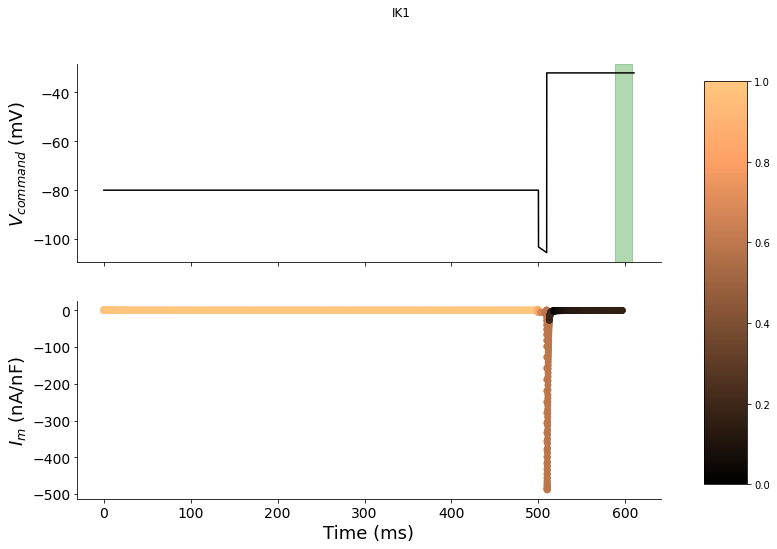

In [8]:
current = 'IK1'
tr.plot_currents_contribution(current, window=window, step_size=step_size, is_shown=True, title=current, saved_to=None)  # f'./ga_results/{trial_conditions}/{current}.svg'

In [9]:
import simulator_scipy
'''
Simulation with Scipy
'''
model_scipy = ORD2011(protocol)
sim_scipy = simulator_scipy.Simulator(model_scipy)

start_time = time.time()

# model_scipy.cell.mode = cells['Epicardial']
# model_scipy.y0[1:] = y0_myokit
# y0 = sim_scipy.pre_simulate( pre_step=5000, protocol='constant' )   
sol_scipy = sim_scipy.simulate(t_span=t_span, t_eval=None, method='BDF', max_step=1.0, atol=1e-8, rtol=1e-8) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.001
# sol_scipy = sim_scipy.simulate2( t_eval, max_step=1e-5*100000, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1E-3*self.time_conversion,  atol=1E-2, rtol=1E-4
command_voltages = [protocol.get_voltage_at_time(t) for t in sol_scipy.t]  

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.7930281162261963 seconds ---


In [10]:
tr2 = mod_trace.Trace(protocol,
                 cell_params=None,
                 t=sol_scipy.t,
                 y=command_voltages,  # simulator.model.V,
                 command_voltages=command_voltages,
                 current_response_info=model_scipy.current_response_info,
                 default_unit=None)   

In [11]:
scale = 1
max_contributions = tr2.current_response_info.get_max_current_contributions(
                time=sol_scipy.t,
                window=window/scale,
                step_size=step_size/scale)
print(max_contributions)

  Current  Contribution  Time Start  Time End
0    I_Na      0.868472       510.0     530.0
1   I_NaL      0.679328       545.0     565.0
2    I_to      0.040319       590.0     610.0
3   I_CaL      0.144072       590.0     610.0
4    I_Kr      0.006300       590.0     610.0
5    I_Ks      0.000170       590.0     610.0
6    I_K1      0.997863       485.0     505.0


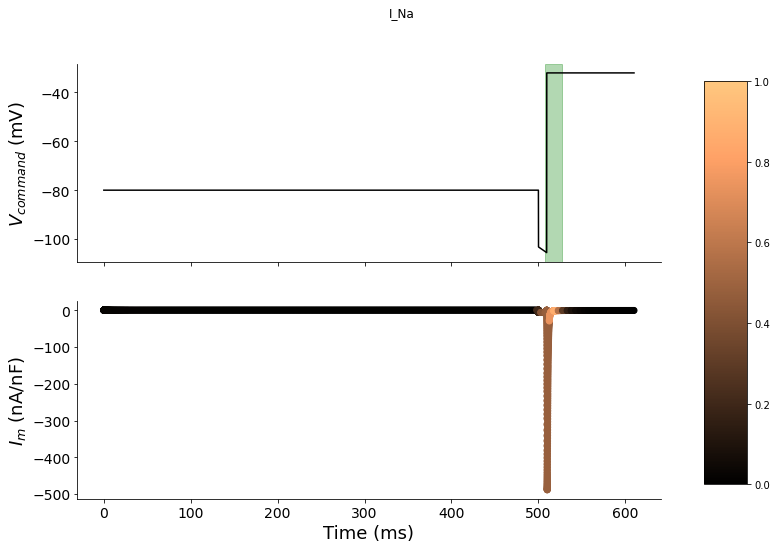

In [12]:
current = 'I_Na'
tr2.plot_currents_contribution(current, window=window, step_size=step_size, is_shown=True, title=current,
        saved_to=None)  # f'./ga_results/{trial_conditions}/{current}.svg'